In [1]:
from pandas import read_csv, DataFrame
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error

from HTML import config as Config
from HTML.save import save_prediction

In [2]:
def datetime_parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

In [3]:
series = read_csv(Config.train_label_path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=datetime_parser)

### Line plot

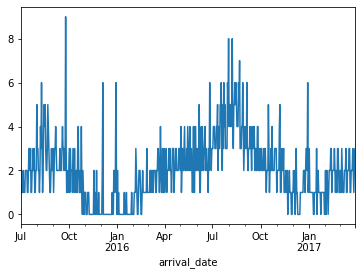

In [4]:
series.plot()
plt.show()

### Autocorrelation

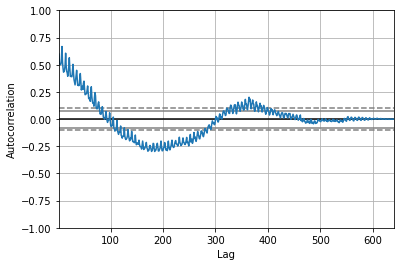

In [5]:
autocorrelation_plot(series)
plt.show()

### ARIMA

In [6]:
series.index = series.index.to_period('M')

In [8]:
# fit model
model = ARIMA(series, order=(50,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  label   No. Observations:                  640
Model:                ARIMA(50, 1, 0)   Log Likelihood                -858.218
Date:                Thu, 17 Dec 2020   AIC                           1818.435
Time:                        13:25:29   BIC                           2045.890
Sample:                    07-31-2015   HQIC                          1906.728
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7837      0.040    -19.507      0.000      -0.862      -0.705
ar.L2         -0.6788      0.052    -13.115      0.000      -0.780      -0.577
ar.L3         -0.5709      0.061     -9.300      0.0

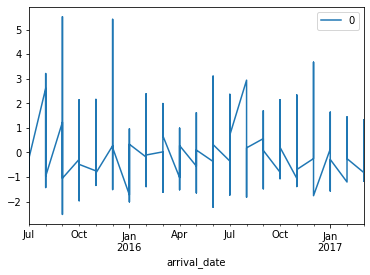

In [9]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

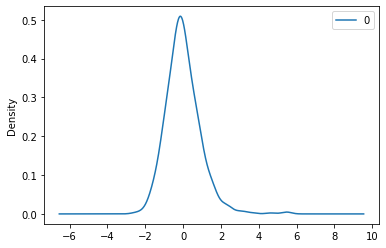

In [10]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [11]:
# summary stats of residuals
print(residuals.describe())

                0
count  640.000000
mean     0.009738
std      0.928640
min     -2.521391
25%     -0.547910
50%     -0.089581
75%      0.479677
max      5.520804


### Evaluation

In [ ]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(50,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'[{t+1}/{len(test)}] predicted=%f, expected=%f' % (yhat, obs), end='\r')

In [ ]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(np.round(predictions), color='red')
plt.show()

### Prediction

In [55]:
series_test = read_csv(Config.test_nolabel_path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=datetime_parser)
series_test.index = series_test.index.to_period('M')

In [84]:
train, test = series.values.astype(int), [None] * len(series_test)
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    test[t] = min(max(0, np.round(yhat)), 9)
    obs = test[t]
    history.append(obs)
    print(f'[{t+1}/{len(test)}] predicted=%f, expected=%f' % (yhat, obs), end='\r')

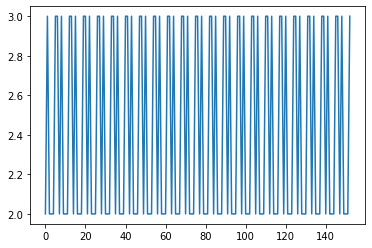

In [85]:
plt.plot(test)
plt.show()

In [89]:
test_df = read_csv(Config.test_nolabel_path)

In [94]:
save_prediction('../outputs/arima_10.csv', test_df['arrival_date'], np.array(test))